Training with **Sentinel-1 GRD** data (IW mode, VV+VH polarization). This notebook is a replica of the notebook for the training with Sentinel-2 data, but with minor adjustments to adapt it to Sentinel-1 images.

# 0. Setup

## 0.1. Libraries

In [ ]:
# Utilities
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Deep learning
import torch
from torch import nn, utils
from torchmetrics import classification

# Custom library
from library import nn_model, utilities, visualizations, preprocessing

# Device
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
device = torch.device(device)
print(f'Using device: {device}')

# Utilities
seed = 42
utilities.set_seed(seed)

Using device: cuda
Seed set to 42 for NumPy, Torch and Random for reproducibility.


## 0.2. Setting the path to the training data

We set the path to the tiles that have been created in the preprocessing notebook, `3_preprocessing.ipynb`.

In [2]:
base_input_dir = '/media/pablo/Shared files/data/'  # Adjust this path to your data directory containing the labelled dataset
input_labelled_dir = os.path.join(base_input_dir, 'Satellite_burned_area_dataset')  # Path to the original labelled dataset
tile_dir = os.path.join(base_input_dir, 'tiled_labelled_dataset')  # Path to the tiled dataset
sentinel_type = 1  # Sentinel-1 data

## 0.3. Notebook description

We train a multi-class segmentation model that assesses wildfire severity using satellite images **from Sentinel-2 L2A** (the "natural-looking" images). Additional steps applied during training:
- Randomly shuffle the tiles (done at the training stage).
- Apply data augmentation techniques to improve the robustness of the model. The authors implement the following transformations (we will do similar but different ones, this is just as reference): "*We applied the following transformations: rotation (up to 50° on both sides), shear (up to 20°), horizontal flip, and vertical flip, all of them with a probability of 50%.*"
- If computationally feasible, we will do cross-fold validation. Otherwise, we will just divide the data statically into training, validation and test. The authors use "*a 7-fold cross-validation approach [...]: 5 folds were used as a training set, 1 fold as a validation set, and 1 fold as a test set.*"
- Adjust the training hyperparameters: "*16GB. The training was performed using 50 epochs, the Adam optimizer with a learning rate of 0.0001 with no weight decay. The Dice loss was used for training. [...] We implemented an early stopping mechanism with patience of 5 epochs and tolerance of 0.01 on validation loss. The final evaluation is performed on the test set.*"

> The final goal is to train a model that estimates the severity of a wildfire using post-wildfire (1 month after) imagery, and then to run inference with the satellite images from wildfires in Catalunya in the last decade. Severity estimation will be done at the pixel level.

We are going to use the U-Net architecture:

![U-Net model](unet_diagram.jpg)

# 1. Preparing the data

## 1.1. Getting the image and masks paths

In [3]:
# Get all of the folders within the tiles directory
fire_folders = sorted([f for f in os.listdir(tile_dir) if os.path.isdir(os.path.join(tile_dir, f))])
# Print the first 5 folders
print("First 5 fire folders:")
print(fire_folders[:5])
# Print the total number of fire folders
print("Total number of fire folders:", len(fire_folders))

# Get the paths for the images and the labels
image_paths = []
label_paths = []
for fire_folder in fire_folders:
    print(f"Fire folder: {fire_folder}")
    images_path = os.path.join(tile_dir, fire_folder, 'images')
    labels_path = os.path.join(tile_dir, fire_folder, 'masks')
    if os.path.exists(images_path):
        image_paths.append(sorted([os.path.join(images_path, img) for img in os.listdir(images_path) if img.startswith(f'sentinel{sentinel_type}') and img.endswith('.tiff')]))
    else:
        print(f"Images path does not exist: {images_path}")
    if os.path.exists(labels_path):
        label_paths.append(sorted([os.path.join(labels_path, lbl) for lbl in os.listdir(labels_path) if lbl.endswith('.tiff')]))
    else:
        print(f"Labels path does not exist: {labels_path}")
# Print the first 5 image paths
print(f"First 5 image and label paths of the fire folder: {fire_folders[0]}")
print(image_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of images for a specific fire folder
print(label_paths[0][:5])  # The result is a list of lists, where each sublist contains the paths of labels for a specific fire folder

# Print the total number of lists in image_paths and label_paths (should be equal to the number of fire folders)
print("Total number of fire folders in image_paths:", len(image_paths))
print("Total number of fire folders in label_paths:", len(label_paths))

First 5 fire folders:
['EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector', 'EMSR207_02LOUSA_02GRADING_MAP_v2_vector', 'EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector', 'EMSR207_04AVELAR_02GRADING_MAP_v2_vector', 'EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector']
Total number of fire folders: 73
Fire folder: EMSR207_01MIRANDADOCORVO_02GRADING_MAP_v2_vector
Fire folder: EMSR207_02LOUSA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_03PAMPILHOSADASERRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_04AVELAR_02GRADING_MAP_v2_vector
Fire folder: EMSR207_05PEDROGAOGRANDE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_06MADEIRA_02GRADING_MAP_v2_vector
Fire folder: EMSR207_07ALVAIAZERE_02GRADING_MAP_v2_vector
Fire folder: EMSR207_08CERNACHEDOBONJARDIM_02GRADING_MAP_v2_vector
Fire folder: EMSR207_10ORVALHO_02GRADING_MAP_v2_vector
Fire folder: EMSR209_01MOGUER_02GRADING_MAP_v2_vector
Fire folder: EMSR209_02MAZAGON_02GRADING_MAP_v2_vector
Fire folder: EMSR209_03LOSCABEZUDOS_02GRADING_MAP_v1_vecto

## 1.2. Loading the image and masks into tensors

We load the images and labels as `torch.Tensor` of dimensions $n \times d \times h \times w$, where:
- $n$: number of images (tiles)/masks.
- $d$: number of channels for the images/masks.
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

We normalize each channel to $N[0,1]$ and set the data type as `torch.float32` (set to `torch.float16` for greater memory efficiency). Why we normalize image channels:

1. **Gradient stability**: Different channels may have vastly different value ranges, leading to unstable gradients
2. **Training speed**: Normalized inputs help the optimizer converge faster
3. **Weight initialization**: Most weight initialization schemes assume normalized inputs
4. **Activation functions**: Work optimally with inputs in specific ranges

In [38]:
# Flatten the lists of image and label paths
images_flat = [item for sublist in image_paths for item in sublist]
labels_flat = [item for sublist in label_paths for item in sublist]

# Remember that there are no S1 images for the event "EMSR368_AOI01_GRA_PRODUCT_r1_RTP01_v3_vector"
# (shown in the preprocessing notebook), so we will remove them from the labels list
labels_flat = [label for label in labels_flat if 'EMSR368_AOI01_GRA_PRODUCT_r1_RTP01_v3_vector' not in label]

# Read images and labels and stack them into a single tensor (reduce precision to float16 for greater efficiency)
images = torch.stack([utilities.read_tiff_to_torch(file_path = image, dtype=torch.float32, normalize=True, normalization_method='per_channel') for image in images_flat])
labels_raw = torch.stack([utilities.read_tiff_to_torch(file_path = label, dtype = torch.float32, normalize=True, normalization_method='255') for label in labels_flat])  # Masks are encoded in 0-255 range according to the paper

Now, let's check the array dimensions and display several image–label pairs to ensure that they are correctly aligned.

In [39]:
print('Size of the image tensor:', images.size())
print('Size of the label tensor:', labels_raw.size())

# Check if the number of images and labels are equal
if images.size(0) != labels_raw.size(0):
    raise ValueError('Number of images and labels do not match!')

Size of the image tensor: torch.Size([3176, 4, 256, 256])
Size of the label tensor: torch.Size([3176, 1, 256, 256])


i.e., in this case:

- $n$: we have 3,176 images and masks (3,374 images before removing those without coverage in the EDA notebook; and there were 54 images missing images from Sentinel-1 for a wildfire in the dataset).
- $d$: number of channels for the images/masks. The images have 4 dimensions (VV, 2VH, |VV|/|VH|/100 plus the coverage -validity- mask, in this order, see https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Data/S1GRD.html#available-bands-and-data).
- $h$: height of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.
- $w$: width of the images and of the masks. Both are of 256 height, as designed in `3_preprocessing`.

For simplicity, we will not be removing the coverage mask dimension as it will not affect training (all pixels without coverage were already removed in the EDA notebook, so the values are uniform).

## 1.3. Checking the alignment: displaying several image-label pairs

Input channels for these Sentinel-1 images are (in this order): VV, VH, VV/VH ratio, and VV/VH difference. A common and informative false-color composite for dual-polarization (VV+VH) Sentinel-1 data uses VV for the red channel, VH for the green channel, and the VV/VH ratio for the blue channel. This helps distinguish between different land cover types.

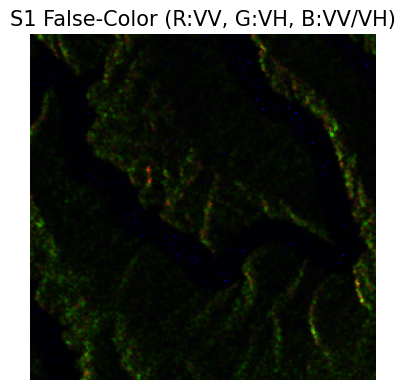

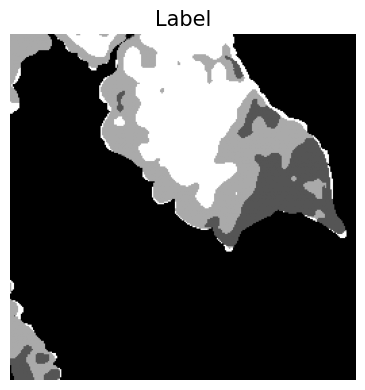

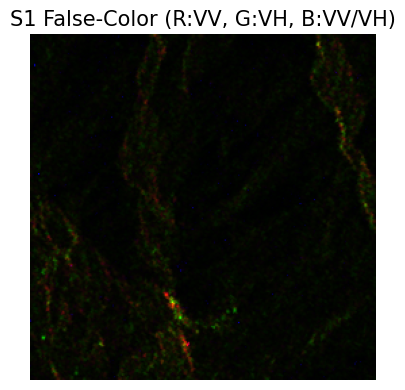

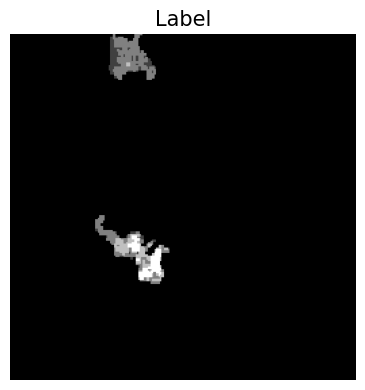

In [45]:
# Displays random images, labels and images
for i in torch.randint(0, len(images), (2,)):
  visualizations.display_image(image = images[i], title = 'S1 False-Color (R:VV, G:VH, B:VV/VH)', rgb_bands=(0, 1, 2))
  visualizations.display_image(image = labels_raw[i], title = 'Label')

Note that, in this case, **the brighter the label in the mask, the higher the severity of the fire (white if maximum severity)**. Areas affected by fires of lower severity are darker. 

## 1.4. Mapping the classes to integers 

In [7]:
# Apply the mapping
labels = utilities.map_labels_to_classes_approximate(labels_raw)

del labels_raw  # Free up memory

In [8]:
# Print the unique values in the labels tensor to verify the mapping
print("Unique values in the labels tensor after mapping:", torch.unique(labels))

Unique values in the labels tensor after mapping: tensor([0, 1, 2, 3, 4])


## 1.5. Formatting the data as a `TensorDataset`

Useful documentation: [`torch.utils.data`](https://pytorch.org/docs/stable/data.html)

In [9]:
# Format the data as a TensorDataset
dataset = utils.data.TensorDataset(images, labels)  # Create a TensorDataset from the image and label tensors
print(len(dataset))

3176


## 1.6. Splitting data into train, validation and test

We split into 70% training data, 15% validation and 15% test.

In [10]:
# Split the dataset into training, validation and test sets
train_dataset, val_dataset, test_dataset = utils.data.random_split(dataset, [0.7, 0.15, 0.15], generator=torch.Generator().manual_seed(seed))

# Set batch size
batch_size = 64

# Set number of physical CPU cores (as int) to use for data loading
num_workers = os.cpu_count() // 2 if os.cpu_count() is not None else 0

# Create DataLoaders for each dataset
train_loader = utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,  # Shuffle the training data to prevent learning order bias, overfitting and improve generalization
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

val_loader = utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep validation data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

test_loader = utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # Keep test data in the same order for consistent evaluation
    num_workers=num_workers,  # Use multiple workers for faster data loading
    pin_memory=True if device == 'cuda' else False,  # Pin memory for faster data transfer to GPU
)

# 2. Training and validation

## 2.1. Neural Network Architecture

![U-Net model](unet_diagram.jpg)

The basic structure of this network is the following:

1. **Input**: a tensor of shape $(N, D, H, W)$.
2. **Encode** down through five levels, doubling channels each time and halving spatial dimensions.
3. **Bottleneck**: deepest features at 128 channels.
4. **Decode** back up, halving channels and doubling spatial dimensions, while concatenating corresponding encoder features to preserve fine details.
5. **Output**: apply a 1×1 convolution → Sigmoid to produce a mask of shape $(N, 1, H, W)$ with values in (0,1).

All of the classes below initialize the parameters at each layer with `__init__` and then implement a `forward` method that defines the forward pass of the neural network, which "takes the input data and passes it through the layers of the network to produce the output. This method is executed whenever the model is called to make a prediction or to compute the loss during training" ([reference](https://discuss.pytorch.org/t/what-is-the-difference-init-and-forward-in-a-network-model/173907)).

### The double convolution

The two convolutional layers are included everywhere in the network, from the encoding to the decoding. For more information, check `DoubleConv` in the library `library`.

Useful sources:
- [`Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) - convolutional layer
- [`BatchNorm2d`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d) - normalization layer
- [`ReLU`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) - non-linear activation function

### The encoder module (`Down`)

The class below represents one encoding step. For more information, check `Down` in the library `library`.

Useful sources:
- [`MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d) - pooling layer

### The decoder module (`Up`)

This class represents one decoding step. It performs upsampling and concatenation with skip connection. For more information, check `Up` in the library `library`.

This class:

1. Upsamples via either bilinear interpolation or a learnable transposed convolution. See [`nn.Upsample`](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html#torch.nn.Upsample)
2. Pads if the resulting feature-map is off by 1 pixel in height/width. See [`nn.functional.pad`](https://pytorch.org/docs/stable/generated/torch.nn.functional.pad.html#torch.nn.functional.pad)
3. Concatenates with the corresponding encoder feature-map along the channel dimension (the “skip connection”). See [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html)
4. Uses `DoubleConv` to fuse and refine these combined features.

### Final 1 $\times$ 1 convolution

This convolution reduces the channels from whatever the last decoder output is (in the diagram, 8) down to the desired number of classes (1 for binary mask, as in this case - 0 for no building and 1 for building). For more information, check `OutConv` in the library `library`.

### Putting all together in `UNet`

This class uses the constructions made above, and replicates the structure of the neural network in the diagram. For more information, check `UNet` in the library `library`.

Note that the output layer returns the logits, not probabilities, for compatibility with the loss function.

## 2.2. Training setup

### Model initialization

In [11]:
# Set the parameters for the U-Net model
n_channels = images.size()[1]  # Number of input channels (4 for Sentinel-1 in this case: VV, VH, VV/VH ratio, and VV/VH difference)
n_classes = 5  # Number of output channels (5 classes: 0: not burned, 1-4: burned area with different severity levels, from lower to higher severity)
base_filters = 8  # Number of filters in the first layer (check diagram)
dropout_p = 0.1  # Dropout probability for regularization
bilinear = False  # Use bilinear interpolation for upsampling (True) or transposed convolution (False)

# Initialize the model
model = nn_model.UNet(
    n_channels=n_channels,
    n_classes=n_classes, 
    base_filters=base_filters,
    dropout_p=dropout_p,
    bilinear=bilinear
)
model = model.to(device)  # Move the model to the specified device (GPU or CPU)
print(model)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Dropout2d(p=0.1, inplace=False)
    )
  )
  (down1): Down(
    (pool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1),

### Loss function (addresses class imbalance)

Simple weights where we weight more the less common classes, and underweight the most common ones.

In [12]:
# Calculate class frequencies and weights
def calculate_class_weights(labels_tensor, n_classes=5):
    """
    Calculate class weights for handling class imbalance
    """
    # Flatten the labels tensor to count occurrences
    labels_flat = labels_tensor.flatten()
    
    # Count occurrences of each class
    class_counts = torch.bincount(labels_flat, minlength=n_classes)
    
    # Calculate total number of pixels
    total_pixels = labels_flat.numel()
    
    # Calculate class frequencies
    class_frequencies = class_counts.float() / total_pixels
    
    # Calculate inverse frequency weights (more weight for less frequent classes)
    class_weights = 1.0 / (class_frequencies + 1e-6)  # Add small epsilon to avoid division by zero
    
    # Normalize weights so they sum to n_classes (optional, helps with stability)
    class_weights = class_weights / class_weights.sum() * n_classes
    
    return class_weights, class_counts, class_frequencies

# Calculate class weights
class_weights, class_counts, class_frequencies = calculate_class_weights(labels, n_classes=5)

# Print class statistics
print("Class distribution:")
for i in range(5):
    print(f"Class {i}: {class_counts[i].item():,} pixels ({class_frequencies[i].item():.4f})")

print(f"\nClass weights: {class_weights}")

Class distribution:
Class 0: 170,226,358 pixels (0.8178)
Class 1: 21,558,899 pixels (0.1036)
Class 2: 5,300,982 pixels (0.0255)
Class 3: 5,598,256 pixels (0.0269)
Class 4: 5,457,841 pixels (0.0262)

Class weights: tensor([0.0487, 0.3848, 1.5648, 1.4818, 1.5199])


In [13]:
# Create the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

More information about the [`CrossEntropyLoss`](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) class. Relevant things to consider:
- "Useful when training a classification problem with *C* classes".
- "The input is expected to contain the unnormalized logits for each class".

### Optimization algorithm

In [ ]:
# We set the parameters of the optimizer like the authors of the paper 
# (see section 0.3 of the notebook)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=1e-2,  # Learning rate (relatively high to skip plateaus)
    weight_decay=1e-5  # Weight decay (L2 regularization)
)

References: [`torch.optim`](https://pytorch.org/docs/stable/optim.html)

## 2.3. Train-validation routine

[Basic guide](https://machinelearningmastery.com/creating-a-training-loop-for-pytorch-models/?utm_source=chatgpt.com) for creating a training loop.

This training routine includes (for more information, check out `train_model` in `library`):

1. Progress tracking with tqdm progress bars for both training and validation steps
2. Loss and IoU calculation for both training and validation sets. The IoU (Intersection over Union) metric is appropriate for segmentation tasks as it measures the overlap between the predicted segmentation and the ground truth.
3. Early stopping that monitors validation loss and stops training when no improvement is seen for a certain number of epochs
4. Best model saving that saves the model parameters (from the initialization in 5), weights with the lowest validation loss
5. Visualization of metrics to monitor the training process and check for overfitting

### Estimating the model weights

In [34]:
# Set training parameters, again, as in the paper (see section 0.3 of the notebook)
num_epochs = 300  # Maximum number of epochs to train
patience = 20  # Number of epochs with no improvement after which training will be stopped
delta = 0.0005  # Tolerance (minimum change in validation loss to qualify as improvement)

# Train the model
model, history, best_val_loss = nn_model.train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_classes=5,
    num_epochs=num_epochs,
    patience=patience,
    delta=delta
)

Epoch 1/300
--------------------------------------------------


Val Loss: 1.6674: 100%|██████████| 8/8 [00:00<00:00,  8.85it/s]


Training Loss: 1.6994, IoU: 0.0815
Validation Loss: 1.6294, IoU: 0.0170
Validation loss improved from inf to 1.6294

Epoch 2/300
--------------------------------------------------


Val Loss: 1.6001: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

Training Loss: 1.6074, IoU: 0.0384
Validation Loss: 1.6034, IoU: 0.0758
Validation loss improved from 1.6294 to 1.6034

Epoch 3/300
--------------------------------------------------



Val Loss: 1.5838: 100%|██████████| 8/8 [00:00<00:00,  8.84it/s]


Training Loss: 1.5961, IoU: 0.0671
Validation Loss: 1.5836, IoU: 0.0762
Validation loss improved from 1.6034 to 1.5836

Epoch 4/300
--------------------------------------------------


Val Loss: 1.5430: 100%|██████████| 8/8 [00:00<00:00,  8.68it/s]

Training Loss: 1.5908, IoU: 0.0846
Validation Loss: 1.5704, IoU: 0.0536
Validation loss improved from 1.5836 to 1.5704

Epoch 5/300
--------------------------------------------------



Val Loss: 1.5287: 100%|██████████| 8/8 [00:00<00:00,  8.61it/s]

Training Loss: 1.5822, IoU: 0.0447
Validation Loss: 1.5673, IoU: 0.0573
Validation loss improved from 1.5704 to 1.5673

Epoch 6/300
--------------------------------------------------



Val Loss: 1.4137: 100%|██████████| 8/8 [00:00<00:00,  8.76it/s]

Training Loss: 1.5747, IoU: 0.0550
Validation Loss: 1.5398, IoU: 0.0565
Validation loss improved from 1.5673 to 1.5398

Epoch 7/300
--------------------------------------------------



Val Loss: 1.5434: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.5713, IoU: 0.0577
Validation Loss: 1.5741, IoU: 0.0558
No improvement in validation loss for 1 epochs

Epoch 8/300
--------------------------------------------------



Val Loss: 2.1717: 100%|██████████| 8/8 [00:00<00:00,  8.71it/s]

Training Loss: 1.5736, IoU: 0.0504
Validation Loss: 1.7712, IoU: 0.0468
No improvement in validation loss for 2 epochs

Epoch 9/300
--------------------------------------------------



Val Loss: 1.4571: 100%|██████████| 8/8 [00:00<00:00,  8.77it/s]

Training Loss: 1.5678, IoU: 0.0675
Validation Loss: 1.5608, IoU: 0.0466
No improvement in validation loss for 3 epochs

Epoch 10/300
--------------------------------------------------



Val Loss: 1.4437: 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

Training Loss: 1.5712, IoU: 0.0617
Validation Loss: 1.5310, IoU: 0.0543
Validation loss improved from 1.5398 to 1.5310

Epoch 11/300
--------------------------------------------------



Val Loss: 1.4391: 100%|██████████| 8/8 [00:00<00:00,  8.67it/s]


Training Loss: 1.5550, IoU: 0.0520
Validation Loss: 1.5239, IoU: 0.0538
Validation loss improved from 1.5310 to 1.5239

Epoch 12/300
--------------------------------------------------


Val Loss: 1.4318: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

Training Loss: 1.5682, IoU: 0.0484
Validation Loss: 1.5360, IoU: 0.0520
No improvement in validation loss for 1 epochs

Epoch 13/300
--------------------------------------------------



Val Loss: 1.4615: 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]

Training Loss: 1.5550, IoU: 0.0514
Validation Loss: 1.5252, IoU: 0.0654
No improvement in validation loss for 2 epochs

Epoch 14/300
--------------------------------------------------



Val Loss: 1.4353: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

Training Loss: 1.5575, IoU: 0.0614
Validation Loss: 1.5220, IoU: 0.0592
Validation loss improved from 1.5239 to 1.5220

Epoch 15/300
--------------------------------------------------



Val Loss: 1.4499: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

Training Loss: 1.5526, IoU: 0.0522
Validation Loss: 1.5415, IoU: 0.0552
No improvement in validation loss for 1 epochs

Epoch 16/300
--------------------------------------------------



Val Loss: 1.4692: 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

Training Loss: 1.5533, IoU: 0.0595
Validation Loss: 1.5443, IoU: 0.0578
No improvement in validation loss for 2 epochs

Epoch 17/300
--------------------------------------------------



Val Loss: 1.5001: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

Training Loss: 1.5646, IoU: 0.0612
Validation Loss: 1.5502, IoU: 0.0680
No improvement in validation loss for 3 epochs

Epoch 18/300
--------------------------------------------------



Val Loss: 1.4277: 100%|██████████| 8/8 [00:00<00:00,  8.64it/s]


Training Loss: 1.5577, IoU: 0.0568
Validation Loss: 1.5396, IoU: 0.0613
No improvement in validation loss for 4 epochs

Epoch 19/300
--------------------------------------------------


Val Loss: 1.4189: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

Training Loss: 1.5410, IoU: 0.0600
Validation Loss: 1.5202, IoU: 0.0596
Validation loss improved from 1.5220 to 1.5202

Epoch 20/300
--------------------------------------------------



Val Loss: 1.3820: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]

Training Loss: 1.5322, IoU: 0.0619
Validation Loss: 1.5056, IoU: 0.0605
Validation loss improved from 1.5202 to 1.5056

Epoch 21/300
--------------------------------------------------



Val Loss: 1.4436: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]

Training Loss: 1.5495, IoU: 0.0665
Validation Loss: 1.5164, IoU: 0.0970
No improvement in validation loss for 1 epochs

Epoch 22/300
--------------------------------------------------



Val Loss: 1.4208: 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

Training Loss: 1.5405, IoU: 0.0673
Validation Loss: 1.5354, IoU: 0.0977
No improvement in validation loss for 2 epochs

Epoch 23/300
--------------------------------------------------



Val Loss: 1.3790: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

Training Loss: 1.5450, IoU: 0.0809
Validation Loss: 1.5045, IoU: 0.0746
Validation loss improved from 1.5056 to 1.5045

Epoch 24/300
--------------------------------------------------



Val Loss: 1.4510: 100%|██████████| 8/8 [00:00<00:00,  8.31it/s]

Training Loss: 1.5335, IoU: 0.0651
Validation Loss: 1.5077, IoU: 0.0782
No improvement in validation loss for 1 epochs

Epoch 25/300
--------------------------------------------------



Val Loss: 1.3845: 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]


Training Loss: 1.5431, IoU: 0.0808
Validation Loss: 1.5040, IoU: 0.0892
Validation loss improved from 1.5045 to 1.5040

Epoch 26/300
--------------------------------------------------


Val Loss: 1.3861: 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

Training Loss: 1.5296, IoU: 0.0669
Validation Loss: 1.4937, IoU: 0.0749
Validation loss improved from 1.5040 to 1.4937

Epoch 27/300
--------------------------------------------------



Val Loss: 1.4810: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Training Loss: 1.5324, IoU: 0.0756
Validation Loss: 1.5273, IoU: 0.0654
No improvement in validation loss for 1 epochs

Epoch 28/300
--------------------------------------------------



Val Loss: 1.3564: 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

Training Loss: 1.5331, IoU: 0.0781
Validation Loss: 1.4864, IoU: 0.0865
Validation loss improved from 1.4937 to 1.4864

Epoch 29/300
--------------------------------------------------



Val Loss: 1.5199: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.5346, IoU: 0.0790
Validation Loss: 1.5453, IoU: 0.0936
No improvement in validation loss for 1 epochs

Epoch 30/300
--------------------------------------------------



Val Loss: 1.3332: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Training Loss: 1.5356, IoU: 0.0941
Validation Loss: 1.5115, IoU: 0.1221
No improvement in validation loss for 2 epochs

Epoch 31/300
--------------------------------------------------



Val Loss: 1.5971: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Training Loss: 1.5227, IoU: 0.0913
Validation Loss: 1.5378, IoU: 0.0747
No improvement in validation loss for 3 epochs

Epoch 32/300
--------------------------------------------------



Val Loss: 1.4316: 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

Training Loss: 1.5247, IoU: 0.0776
Validation Loss: 1.5158, IoU: 0.0849
No improvement in validation loss for 4 epochs

Epoch 33/300
--------------------------------------------------



Val Loss: 1.3767: 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

Training Loss: 1.5279, IoU: 0.0852
Validation Loss: 1.5065, IoU: 0.0971
No improvement in validation loss for 5 epochs

Epoch 34/300
--------------------------------------------------



Val Loss: 1.2313: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]

Training Loss: 1.5184, IoU: 0.0848
Validation Loss: 1.4901, IoU: 0.0757
No improvement in validation loss for 6 epochs

Epoch 35/300
--------------------------------------------------



Val Loss: 1.4214: 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

Training Loss: 1.5216, IoU: 0.0726
Validation Loss: 1.4890, IoU: 0.1056
No improvement in validation loss for 7 epochs

Epoch 36/300
--------------------------------------------------



Val Loss: 1.4472: 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

Training Loss: 1.5245, IoU: 0.0816
Validation Loss: 1.5197, IoU: 0.0868
No improvement in validation loss for 8 epochs

Epoch 37/300
--------------------------------------------------



Val Loss: 1.3918: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

Training Loss: 1.5181, IoU: 0.0982
Validation Loss: 1.4837, IoU: 0.1097
Validation loss improved from 1.4864 to 1.4837

Epoch 38/300
--------------------------------------------------



Val Loss: 1.3117: 100%|██████████| 8/8 [00:00<00:00,  8.31it/s]

Training Loss: 1.5204, IoU: 0.0804
Validation Loss: 1.4984, IoU: 0.0764
No improvement in validation loss for 1 epochs

Epoch 39/300
--------------------------------------------------



Val Loss: 1.4805: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]


Training Loss: 1.5210, IoU: 0.0929
Validation Loss: 1.5316, IoU: 0.0894
No improvement in validation loss for 2 epochs

Epoch 40/300
--------------------------------------------------


Val Loss: 1.4684: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

Training Loss: 1.5233, IoU: 0.0906
Validation Loss: 1.5371, IoU: 0.0889
No improvement in validation loss for 3 epochs

Epoch 41/300
--------------------------------------------------



Val Loss: 1.4617: 100%|██████████| 8/8 [00:00<00:00,  8.65it/s]

Training Loss: 1.5147, IoU: 0.0974
Validation Loss: 1.5040, IoU: 0.0888
No improvement in validation loss for 4 epochs

Epoch 42/300
--------------------------------------------------



Val Loss: 1.4631: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]


Training Loss: 1.5190, IoU: 0.0824
Validation Loss: 1.4944, IoU: 0.1270
No improvement in validation loss for 5 epochs

Epoch 43/300
--------------------------------------------------


Val Loss: 1.3230: 100%|██████████| 8/8 [00:00<00:00,  8.57it/s]

Training Loss: 1.5106, IoU: 0.0989
Validation Loss: 1.4950, IoU: 0.1029
No improvement in validation loss for 6 epochs

Epoch 44/300
--------------------------------------------------



Val Loss: 1.2352: 100%|██████████| 8/8 [00:00<00:00,  8.31it/s]

Training Loss: 1.5060, IoU: 0.0765
Validation Loss: 1.4784, IoU: 0.0659
Validation loss improved from 1.4837 to 1.4784

Epoch 45/300
--------------------------------------------------



Val Loss: 1.5341: 100%|██████████| 8/8 [00:00<00:00,  8.19it/s]

Training Loss: 1.4932, IoU: 0.0855
Validation Loss: 1.5156, IoU: 0.0703
No improvement in validation loss for 1 epochs

Epoch 46/300
--------------------------------------------------



Val Loss: 1.4895: 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]

Training Loss: 1.4952, IoU: 0.0855
Validation Loss: 1.5331, IoU: 0.0759
No improvement in validation loss for 2 epochs

Epoch 47/300
--------------------------------------------------



Val Loss: 1.4164: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]

Training Loss: 1.5152, IoU: 0.0813
Validation Loss: 1.4867, IoU: 0.0896
No improvement in validation loss for 3 epochs

Epoch 48/300
--------------------------------------------------



Val Loss: 1.3589: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]


Training Loss: 1.4995, IoU: 0.0937
Validation Loss: 1.4918, IoU: 0.0882
No improvement in validation loss for 4 epochs

Epoch 49/300
--------------------------------------------------


Val Loss: 1.5842: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


Training Loss: 1.5117, IoU: 0.0896
Validation Loss: 1.5900, IoU: 0.0713
No improvement in validation loss for 5 epochs

Epoch 50/300
--------------------------------------------------


Val Loss: 1.4600: 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

Training Loss: 1.4991, IoU: 0.0830
Validation Loss: 1.5055, IoU: 0.1315
No improvement in validation loss for 6 epochs

Epoch 51/300
--------------------------------------------------



Val Loss: 1.2379: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Training Loss: 1.4964, IoU: 0.0946
Validation Loss: 1.4708, IoU: 0.0994
Validation loss improved from 1.4784 to 1.4708

Epoch 52/300
--------------------------------------------------


Val Loss: 1.3861: 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

Training Loss: 1.4965, IoU: 0.0907
Validation Loss: 1.4848, IoU: 0.1081
No improvement in validation loss for 1 epochs

Epoch 53/300
--------------------------------------------------



Val Loss: 1.2971: 100%|██████████| 8/8 [00:00<00:00,  8.39it/s]

Training Loss: 1.4908, IoU: 0.0920
Validation Loss: 1.4763, IoU: 0.0925
No improvement in validation loss for 2 epochs

Epoch 54/300
--------------------------------------------------



Val Loss: 1.3258: 100%|██████████| 8/8 [00:00<00:00,  8.16it/s]


Training Loss: 1.5004, IoU: 0.0942
Validation Loss: 1.4713, IoU: 0.1135
No improvement in validation loss for 3 epochs

Epoch 55/300
--------------------------------------------------


Val Loss: 1.3201: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]

Training Loss: 1.4789, IoU: 0.0994
Validation Loss: 1.4776, IoU: 0.1159
No improvement in validation loss for 4 epochs

Epoch 56/300
--------------------------------------------------



Val Loss: 1.4449: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

Training Loss: 1.4810, IoU: 0.1056
Validation Loss: 1.5776, IoU: 0.0606
No improvement in validation loss for 5 epochs

Epoch 57/300
--------------------------------------------------



Val Loss: 1.4102: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]


Training Loss: 1.4840, IoU: 0.0989
Validation Loss: 1.5077, IoU: 0.0969
No improvement in validation loss for 6 epochs

Epoch 58/300
--------------------------------------------------


Val Loss: 1.1869: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

Training Loss: 1.4829, IoU: 0.0942
Validation Loss: 1.4881, IoU: 0.1126
No improvement in validation loss for 7 epochs

Epoch 59/300
--------------------------------------------------



Val Loss: 1.3133: 100%|██████████| 8/8 [00:00<00:00,  8.36it/s]

Training Loss: 1.4857, IoU: 0.0913
Validation Loss: 1.4741, IoU: 0.1250
No improvement in validation loss for 8 epochs

Epoch 60/300
--------------------------------------------------



Val Loss: 1.2282: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.4691, IoU: 0.0952
Validation Loss: 1.4683, IoU: 0.1079
Validation loss improved from 1.4708 to 1.4683

Epoch 61/300
--------------------------------------------------



Val Loss: 1.2291: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Training Loss: 1.4870, IoU: 0.0973
Validation Loss: 1.4742, IoU: 0.1017
No improvement in validation loss for 1 epochs

Epoch 62/300
--------------------------------------------------



Val Loss: 1.2841: 100%|██████████| 8/8 [00:00<00:00,  8.26it/s]

Training Loss: 1.4778, IoU: 0.1012
Validation Loss: 1.4698, IoU: 0.1133
No improvement in validation loss for 2 epochs

Epoch 63/300
--------------------------------------------------



Val Loss: 1.3152: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

Training Loss: 1.4809, IoU: 0.0966
Validation Loss: 1.4643, IoU: 0.1110
Validation loss improved from 1.4683 to 1.4643

Epoch 64/300
--------------------------------------------------



Val Loss: 1.5335: 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]

Training Loss: 1.4786, IoU: 0.0982
Validation Loss: 1.5243, IoU: 0.0782
No improvement in validation loss for 1 epochs

Epoch 65/300
--------------------------------------------------



Val Loss: 1.2226: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

Training Loss: 1.4691, IoU: 0.0927
Validation Loss: 1.4590, IoU: 0.1306
Validation loss improved from 1.4643 to 1.4590

Epoch 66/300
--------------------------------------------------



Val Loss: 1.1948: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Training Loss: 1.4686, IoU: 0.0947
Validation Loss: 1.4467, IoU: 0.1244
Validation loss improved from 1.4590 to 1.4467

Epoch 67/300
--------------------------------------------------



Val Loss: 1.2361: 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

Training Loss: 1.4562, IoU: 0.1027
Validation Loss: 1.4502, IoU: 0.1361
No improvement in validation loss for 1 epochs

Epoch 68/300
--------------------------------------------------



Val Loss: 1.3635: 100%|██████████| 8/8 [00:00<00:00,  8.53it/s]

Training Loss: 1.4675, IoU: 0.0972
Validation Loss: 1.4994, IoU: 0.0937
No improvement in validation loss for 2 epochs

Epoch 69/300
--------------------------------------------------



Val Loss: 1.2048: 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

Training Loss: 1.4755, IoU: 0.0939
Validation Loss: 1.4367, IoU: 0.0971
Validation loss improved from 1.4467 to 1.4367

Epoch 70/300
--------------------------------------------------



Val Loss: 1.1776: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

Training Loss: 1.4559, IoU: 0.0993
Validation Loss: 1.4615, IoU: 0.1041
No improvement in validation loss for 1 epochs

Epoch 71/300
--------------------------------------------------



Val Loss: 1.4483: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

Training Loss: 1.4544, IoU: 0.0952
Validation Loss: 1.4749, IoU: 0.1158
No improvement in validation loss for 2 epochs

Epoch 72/300
--------------------------------------------------



Val Loss: 1.1766: 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

Training Loss: 1.4447, IoU: 0.1010
Validation Loss: 1.4451, IoU: 0.0880
No improvement in validation loss for 3 epochs

Epoch 73/300
--------------------------------------------------



Val Loss: 1.3633: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

Training Loss: 1.4741, IoU: 0.0917
Validation Loss: 1.4578, IoU: 0.1086
No improvement in validation loss for 4 epochs

Epoch 74/300
--------------------------------------------------



Val Loss: 1.2670: 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

Training Loss: 1.4546, IoU: 0.0993
Validation Loss: 1.4583, IoU: 0.1093
No improvement in validation loss for 5 epochs

Epoch 75/300
--------------------------------------------------



Val Loss: 1.2042: 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]

Training Loss: 1.4506, IoU: 0.1013
Validation Loss: 1.4594, IoU: 0.1088
No improvement in validation loss for 6 epochs

Epoch 76/300
--------------------------------------------------



Val Loss: 1.2321: 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]


Training Loss: 1.4553, IoU: 0.1076
Validation Loss: 1.4407, IoU: 0.1267
No improvement in validation loss for 7 epochs

Epoch 77/300
--------------------------------------------------


Val Loss: 1.3002: 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

Training Loss: 1.4451, IoU: 0.1010
Validation Loss: 1.5804, IoU: 0.0813
No improvement in validation loss for 8 epochs

Epoch 78/300
--------------------------------------------------



Val Loss: 1.2840: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]


Training Loss: 1.4542, IoU: 0.1030
Validation Loss: 1.4247, IoU: 0.1166
Validation loss improved from 1.4367 to 1.4247

Epoch 79/300
--------------------------------------------------


Val Loss: 1.2553: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

Training Loss: 1.4510, IoU: 0.1063
Validation Loss: 1.4449, IoU: 0.1182
No improvement in validation loss for 1 epochs

Epoch 80/300
--------------------------------------------------



Val Loss: 1.1640: 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

Training Loss: 1.4535, IoU: 0.0990
Validation Loss: 1.5392, IoU: 0.0924
No improvement in validation loss for 2 epochs

Epoch 81/300
--------------------------------------------------



Val Loss: 1.2474: 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

Training Loss: 1.4525, IoU: 0.0986
Validation Loss: 1.4374, IoU: 0.1113
No improvement in validation loss for 3 epochs

Epoch 82/300
--------------------------------------------------



Val Loss: 1.3648: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.4544, IoU: 0.1020
Validation Loss: 1.4734, IoU: 0.1162
No improvement in validation loss for 4 epochs

Epoch 83/300
--------------------------------------------------



Val Loss: 1.2756: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

Training Loss: 1.4416, IoU: 0.0986
Validation Loss: 1.4741, IoU: 0.1143
No improvement in validation loss for 5 epochs

Epoch 84/300
--------------------------------------------------



Val Loss: 1.3063: 100%|██████████| 8/8 [00:00<00:00,  8.18it/s]

Training Loss: 1.4513, IoU: 0.1029
Validation Loss: 1.4532, IoU: 0.1091
No improvement in validation loss for 6 epochs

Epoch 85/300
--------------------------------------------------



Val Loss: 1.3801: 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

Training Loss: 1.4491, IoU: 0.0998
Validation Loss: 1.4718, IoU: 0.1191
No improvement in validation loss for 7 epochs

Epoch 86/300
--------------------------------------------------



Val Loss: 1.1478: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

Training Loss: 1.4329, IoU: 0.1050
Validation Loss: 1.4250, IoU: 0.1178
No improvement in validation loss for 8 epochs

Epoch 87/300
--------------------------------------------------



Val Loss: 1.5771: 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]

Training Loss: 1.4357, IoU: 0.0997
Validation Loss: 1.5476, IoU: 0.0962
No improvement in validation loss for 9 epochs

Epoch 88/300
--------------------------------------------------



Val Loss: 1.2522: 100%|██████████| 8/8 [00:00<00:00,  8.27it/s]

Training Loss: 1.4375, IoU: 0.0987
Validation Loss: 1.4318, IoU: 0.1190
No improvement in validation loss for 10 epochs

Epoch 89/300
--------------------------------------------------



Val Loss: 1.2710: 100%|██████████| 8/8 [00:00<00:00,  8.25it/s]

Training Loss: 1.4300, IoU: 0.0978
Validation Loss: 1.4530, IoU: 0.1155
No improvement in validation loss for 11 epochs

Epoch 90/300
--------------------------------------------------



Val Loss: 1.0966: 100%|██████████| 8/8 [00:00<00:00,  8.22it/s]

Training Loss: 1.4439, IoU: 0.1012
Validation Loss: 1.4293, IoU: 0.0924
No improvement in validation loss for 12 epochs

Epoch 91/300
--------------------------------------------------



Val Loss: 1.2669: 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]

Training Loss: 1.4212, IoU: 0.0969
Validation Loss: 1.4489, IoU: 0.1000
No improvement in validation loss for 13 epochs

Epoch 92/300
--------------------------------------------------



Val Loss: 1.1624: 100%|██████████| 8/8 [00:00<00:00,  8.39it/s]

Training Loss: 1.4119, IoU: 0.1092
Validation Loss: 1.4110, IoU: 0.1016
Validation loss improved from 1.4247 to 1.4110

Epoch 93/300
--------------------------------------------------



Val Loss: 1.2866: 100%|██████████| 8/8 [00:00<00:00,  8.24it/s]

Training Loss: 1.4160, IoU: 0.0963
Validation Loss: 1.4838, IoU: 0.1227
No improvement in validation loss for 1 epochs

Epoch 94/300
--------------------------------------------------



Val Loss: 1.3623: 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

Training Loss: 1.4244, IoU: 0.1098
Validation Loss: 1.4376, IoU: 0.1153
No improvement in validation loss for 2 epochs

Epoch 95/300
--------------------------------------------------



Val Loss: 1.2019: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

Training Loss: 1.4048, IoU: 0.1043
Validation Loss: 1.4695, IoU: 0.1080
No improvement in validation loss for 3 epochs

Epoch 96/300
--------------------------------------------------



Val Loss: 1.1560: 100%|██████████| 8/8 [00:00<00:00,  8.30it/s]

Training Loss: 1.4270, IoU: 0.1059
Validation Loss: 1.4247, IoU: 0.1112
No improvement in validation loss for 4 epochs

Epoch 97/300
--------------------------------------------------



Val Loss: 1.2009: 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

Training Loss: 1.4275, IoU: 0.1120
Validation Loss: 1.4286, IoU: 0.1220
No improvement in validation loss for 5 epochs

Epoch 98/300
--------------------------------------------------



Val Loss: 1.2481: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

Training Loss: 1.4103, IoU: 0.1082
Validation Loss: 1.4334, IoU: 0.1149
No improvement in validation loss for 6 epochs

Epoch 99/300
--------------------------------------------------



Val Loss: 1.2671: 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

Training Loss: 1.4162, IoU: 0.1011
Validation Loss: 1.4209, IoU: 0.1040
No improvement in validation loss for 7 epochs

Epoch 100/300
--------------------------------------------------



Val Loss: 1.1605: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

Training Loss: 1.4117, IoU: 0.1010
Validation Loss: 1.4125, IoU: 0.1044
No improvement in validation loss for 8 epochs

Epoch 101/300
--------------------------------------------------



Val Loss: 1.1807: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

Training Loss: 1.4039, IoU: 0.1046
Validation Loss: 1.4368, IoU: 0.0882
No improvement in validation loss for 9 epochs

Epoch 102/300
--------------------------------------------------



Val Loss: 1.2620: 100%|██████████| 8/8 [00:00<00:00,  8.39it/s]

Training Loss: 1.4060, IoU: 0.0956
Validation Loss: 1.4200, IoU: 0.1170
No improvement in validation loss for 10 epochs

Epoch 103/300
--------------------------------------------------



Val Loss: 1.3116: 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

Training Loss: 1.4053, IoU: 0.1057
Validation Loss: 1.4551, IoU: 0.1146
No improvement in validation loss for 11 epochs

Epoch 104/300
--------------------------------------------------



Val Loss: 1.3770: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

Training Loss: 1.4113, IoU: 0.1049
Validation Loss: 1.4044, IoU: 0.1154
Validation loss improved from 1.4110 to 1.4044

Epoch 105/300
--------------------------------------------------



Val Loss: 1.4879: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]

Training Loss: 1.3995, IoU: 0.1036
Validation Loss: 1.4723, IoU: 0.1273
No improvement in validation loss for 1 epochs

Epoch 106/300
--------------------------------------------------



Val Loss: 1.1979: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]

Training Loss: 1.4069, IoU: 0.1098
Validation Loss: 1.3853, IoU: 0.1248
Validation loss improved from 1.4044 to 1.3853

Epoch 107/300
--------------------------------------------------



Val Loss: 1.1635: 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

Training Loss: 1.4207, IoU: 0.0976
Validation Loss: 1.4292, IoU: 0.0932
No improvement in validation loss for 1 epochs

Epoch 108/300
--------------------------------------------------



Val Loss: 1.2410: 100%|██████████| 8/8 [00:00<00:00,  8.53it/s]

Training Loss: 1.4042, IoU: 0.0941
Validation Loss: 1.4255, IoU: 0.1232
No improvement in validation loss for 2 epochs

Epoch 109/300
--------------------------------------------------



Val Loss: 1.1805: 100%|██████████| 8/8 [00:00<00:00,  8.58it/s]

Training Loss: 1.4061, IoU: 0.1032
Validation Loss: 1.4323, IoU: 0.1003
No improvement in validation loss for 3 epochs

Epoch 110/300
--------------------------------------------------



Val Loss: 1.2766: 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

Training Loss: 1.3979, IoU: 0.1123
Validation Loss: 1.4235, IoU: 0.1120
No improvement in validation loss for 4 epochs

Epoch 111/300
--------------------------------------------------



Val Loss: 1.3363: 100%|██████████| 8/8 [00:00<00:00,  8.43it/s]

Training Loss: 1.4062, IoU: 0.1044
Validation Loss: 1.4120, IoU: 0.1074
No improvement in validation loss for 5 epochs

Epoch 112/300
--------------------------------------------------



Val Loss: 1.2053: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]

Training Loss: 1.3914, IoU: 0.1077
Validation Loss: 1.4343, IoU: 0.1026
No improvement in validation loss for 6 epochs

Epoch 113/300
--------------------------------------------------



Val Loss: 1.2201: 100%|██████████| 8/8 [00:00<00:00,  8.47it/s]

Training Loss: 1.3931, IoU: 0.1131
Validation Loss: 1.4439, IoU: 0.1035
No improvement in validation loss for 7 epochs

Epoch 114/300
--------------------------------------------------



Val Loss: 1.1359: 100%|██████████| 8/8 [00:00<00:00,  8.29it/s]

Training Loss: 1.3964, IoU: 0.1007
Validation Loss: 1.4495, IoU: 0.1138
No improvement in validation loss for 8 epochs

Epoch 115/300
--------------------------------------------------



Val Loss: 1.2247: 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

Training Loss: 1.3951, IoU: 0.1067
Validation Loss: 1.3874, IoU: 0.1122
No improvement in validation loss for 9 epochs

Epoch 116/300
--------------------------------------------------



Val Loss: 1.1560: 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

Training Loss: 1.3908, IoU: 0.1086
Validation Loss: 1.3937, IoU: 0.1219
No improvement in validation loss for 10 epochs

Epoch 117/300
--------------------------------------------------



Val Loss: 1.2120: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.3796, IoU: 0.1056
Validation Loss: 1.3999, IoU: 0.1188
No improvement in validation loss for 11 epochs

Epoch 118/300
--------------------------------------------------



Val Loss: 1.2953: 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

Training Loss: 1.3860, IoU: 0.1111
Validation Loss: 1.4514, IoU: 0.0945
No improvement in validation loss for 12 epochs

Epoch 119/300
--------------------------------------------------



Val Loss: 1.2109: 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]

Training Loss: 1.3914, IoU: 0.1004
Validation Loss: 1.4540, IoU: 0.1225
No improvement in validation loss for 13 epochs

Epoch 120/300
--------------------------------------------------



Val Loss: 1.2211: 100%|██████████| 8/8 [00:00<00:00,  8.38it/s]

Training Loss: 1.3758, IoU: 0.1139
Validation Loss: 1.4825, IoU: 0.1216
No improvement in validation loss for 14 epochs

Epoch 121/300
--------------------------------------------------



Val Loss: 1.4906: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

Training Loss: 1.3903, IoU: 0.1132
Validation Loss: 1.4894, IoU: 0.0875
No improvement in validation loss for 15 epochs

Epoch 122/300
--------------------------------------------------



Val Loss: 1.3940: 100%|██████████| 8/8 [00:00<00:00,  8.37it/s]

Training Loss: 1.3864, IoU: 0.1114
Validation Loss: 1.4114, IoU: 0.1235
No improvement in validation loss for 16 epochs

Epoch 123/300
--------------------------------------------------



Val Loss: 1.2662: 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

Training Loss: 1.3883, IoU: 0.1097
Validation Loss: 1.4241, IoU: 0.1206
No improvement in validation loss for 17 epochs

Epoch 124/300
--------------------------------------------------



Val Loss: 1.1333: 100%|██████████| 8/8 [00:00<00:00,  8.45it/s]

Training Loss: 1.3791, IoU: 0.1253
Validation Loss: 1.3721, IoU: 0.1065
Validation loss improved from 1.3853 to 1.3721

Epoch 125/300
--------------------------------------------------



Val Loss: 1.2326: 100%|██████████| 8/8 [00:00<00:00,  8.59it/s]

Training Loss: 1.3800, IoU: 0.1078
Validation Loss: 1.3908, IoU: 0.1084
No improvement in validation loss for 1 epochs

Epoch 126/300
--------------------------------------------------



Val Loss: 1.0937: 100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


Training Loss: 1.3908, IoU: 0.1059
Validation Loss: 1.4127, IoU: 0.0851
No improvement in validation loss for 2 epochs

Epoch 127/300
--------------------------------------------------


Val Loss: 1.1484: 100%|██████████| 8/8 [00:00<00:00,  8.40it/s]

Training Loss: 1.3801, IoU: 0.0985
Validation Loss: 1.3894, IoU: 0.1054
No improvement in validation loss for 3 epochs

Epoch 128/300
--------------------------------------------------



Val Loss: 1.0846: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]

Training Loss: 1.3826, IoU: 0.1088
Validation Loss: 1.3954, IoU: 0.1427
No improvement in validation loss for 4 epochs

Epoch 129/300
--------------------------------------------------



Val Loss: 1.2205: 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

Training Loss: 1.3740, IoU: 0.1024
Validation Loss: 1.4086, IoU: 0.1155
No improvement in validation loss for 5 epochs

Epoch 130/300
--------------------------------------------------



Val Loss: 1.2600: 100%|██████████| 8/8 [00:00<00:00,  8.35it/s]

Training Loss: 1.3657, IoU: 0.1127
Validation Loss: 1.4148, IoU: 0.1150
No improvement in validation loss for 6 epochs

Epoch 131/300
--------------------------------------------------



Val Loss: 1.2069: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

Training Loss: 1.3613, IoU: 0.1166
Validation Loss: 1.4261, IoU: 0.1173
No improvement in validation loss for 7 epochs

Epoch 132/300
--------------------------------------------------



Val Loss: 1.3333: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]

Training Loss: 1.3644, IoU: 0.1099
Validation Loss: 1.4532, IoU: 0.0854
No improvement in validation loss for 8 epochs

Epoch 133/300
--------------------------------------------------



Val Loss: 1.1699: 100%|██████████| 8/8 [00:00<00:00,  8.20it/s]

Training Loss: 1.3683, IoU: 0.1135
Validation Loss: 1.4125, IoU: 0.1194
No improvement in validation loss for 9 epochs

Epoch 134/300
--------------------------------------------------



Val Loss: 1.1165: 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]

Training Loss: 1.3669, IoU: 0.1108
Validation Loss: 1.4476, IoU: 0.1012
No improvement in validation loss for 10 epochs

Epoch 135/300
--------------------------------------------------



Val Loss: 1.1692: 100%|██████████| 8/8 [00:00<00:00,  8.28it/s]

Training Loss: 1.3657, IoU: 0.1116
Validation Loss: 1.4079, IoU: 0.1353
No improvement in validation loss for 11 epochs

Epoch 136/300
--------------------------------------------------



Val Loss: 1.0724: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]

Training Loss: 1.3710, IoU: 0.1071
Validation Loss: 1.3913, IoU: 0.1134
No improvement in validation loss for 12 epochs

Epoch 137/300
--------------------------------------------------



Val Loss: 1.1808: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.3517, IoU: 0.1175
Validation Loss: 1.3612, IoU: 0.1177
Validation loss improved from 1.3721 to 1.3612

Epoch 138/300
--------------------------------------------------



Val Loss: 1.1005: 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

Training Loss: 1.3669, IoU: 0.1181
Validation Loss: 1.4270, IoU: 0.1481
No improvement in validation loss for 1 epochs

Epoch 139/300
--------------------------------------------------



Val Loss: 1.0769: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Training Loss: 1.3506, IoU: 0.1184
Validation Loss: 1.3689, IoU: 0.1250
No improvement in validation loss for 2 epochs

Epoch 140/300
--------------------------------------------------



Val Loss: 1.3160: 100%|██████████| 8/8 [00:00<00:00,  8.17it/s]


Training Loss: 1.3563, IoU: 0.1226
Validation Loss: 1.4483, IoU: 0.1135
No improvement in validation loss for 3 epochs

Epoch 141/300
--------------------------------------------------


Val Loss: 1.1217: 100%|██████████| 8/8 [00:00<00:00,  8.54it/s]

Training Loss: 1.3542, IoU: 0.1254
Validation Loss: 1.3806, IoU: 0.1368
No improvement in validation loss for 4 epochs

Epoch 142/300
--------------------------------------------------



Val Loss: 1.1420: 100%|██████████| 8/8 [00:00<00:00,  8.11it/s]

Training Loss: 1.3540, IoU: 0.1222
Validation Loss: 1.3816, IoU: 0.1216
No improvement in validation loss for 5 epochs

Epoch 143/300
--------------------------------------------------



Val Loss: 1.2589: 100%|██████████| 8/8 [00:00<00:00,  8.46it/s]

Training Loss: 1.3443, IoU: 0.1312
Validation Loss: 1.4327, IoU: 0.1139
No improvement in validation loss for 6 epochs

Epoch 144/300
--------------------------------------------------



Val Loss: 1.2489: 100%|██████████| 8/8 [00:00<00:00,  8.35it/s]

Training Loss: 1.3610, IoU: 0.1142
Validation Loss: 1.3796, IoU: 0.1130
No improvement in validation loss for 7 epochs

Epoch 145/300
--------------------------------------------------



Val Loss: 1.4412: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

Training Loss: 1.3483, IoU: 0.1104
Validation Loss: 1.4420, IoU: 0.1258
No improvement in validation loss for 8 epochs

Epoch 146/300
--------------------------------------------------



Val Loss: 1.2137: 100%|██████████| 8/8 [00:00<00:00,  8.48it/s]

Training Loss: 1.3456, IoU: 0.1239
Validation Loss: 1.3714, IoU: 0.1192
No improvement in validation loss for 9 epochs

Epoch 147/300
--------------------------------------------------



Val Loss: 1.2530: 100%|██████████| 8/8 [00:00<00:00,  8.60it/s]

Training Loss: 1.3376, IoU: 0.1275
Validation Loss: 1.4013, IoU: 0.1215
No improvement in validation loss for 10 epochs

Epoch 148/300
--------------------------------------------------



Val Loss: 1.1504: 100%|██████████| 8/8 [00:00<00:00,  8.33it/s]

Training Loss: 1.3395, IoU: 0.1292
Validation Loss: 1.3861, IoU: 0.1350
No improvement in validation loss for 11 epochs

Epoch 149/300
--------------------------------------------------



Val Loss: 1.4395: 100%|██████████| 8/8 [00:00<00:00,  8.52it/s]


Training Loss: 1.3332, IoU: 0.1199
Validation Loss: 1.4293, IoU: 0.1477
No improvement in validation loss for 12 epochs

Epoch 150/300
--------------------------------------------------


Val Loss: 1.0859: 100%|██████████| 8/8 [00:00<00:00,  8.44it/s]

Training Loss: 1.3297, IoU: 0.1260
Validation Loss: 1.3756, IoU: 0.1158
No improvement in validation loss for 13 epochs

Epoch 151/300
--------------------------------------------------



Val Loss: 1.1332: 100%|██████████| 8/8 [00:00<00:00,  8.34it/s]

Training Loss: 1.3341, IoU: 0.1276
Validation Loss: 1.4011, IoU: 0.1366
No improvement in validation loss for 14 epochs

Epoch 152/300
--------------------------------------------------



Val Loss: 1.2652: 100%|██████████| 8/8 [00:00<00:00,  8.55it/s]

Training Loss: 1.3405, IoU: 0.1243
Validation Loss: 1.4030, IoU: 0.1331
No improvement in validation loss for 15 epochs

Epoch 153/300
--------------------------------------------------



Val Loss: 1.0698: 100%|██████████| 8/8 [00:00<00:00,  8.21it/s]

Training Loss: 1.3255, IoU: 0.1279
Validation Loss: 1.4096, IoU: 0.1236
No improvement in validation loss for 16 epochs

Epoch 154/300
--------------------------------------------------



Val Loss: 1.3145: 100%|██████████| 8/8 [00:00<00:00,  8.51it/s]


Training Loss: 1.3232, IoU: 0.1186
Validation Loss: 1.3670, IoU: 0.1252
No improvement in validation loss for 17 epochs

Epoch 155/300
--------------------------------------------------


Val Loss: 1.3752: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]

Training Loss: 1.3503, IoU: 0.1238
Validation Loss: 1.4088, IoU: 0.1426
No improvement in validation loss for 18 epochs

Epoch 156/300
--------------------------------------------------



Val Loss: 1.1172: 100%|██████████| 8/8 [00:00<00:00,  8.49it/s]

Training Loss: 1.3178, IoU: 0.1279
Validation Loss: 1.3737, IoU: 0.1348
No improvement in validation loss for 19 epochs

Epoch 157/300
--------------------------------------------------



Val Loss: 1.2199: 100%|██████████| 8/8 [00:00<00:00,  8.42it/s]

Training Loss: 1.3414, IoU: 0.1334
Validation Loss: 1.4207, IoU: 0.1012
No improvement in validation loss for 20 epochs

Early stopping triggered after 157 epochs

Loaded best model weights with validation loss: 1.3612


### Saving the weights and the architecture after training

We use a function to save the model with the optimal weights found after training.

In [35]:
utilities.save_model(model, 
           f'unet_sentinel{sentinel_type}_seed{seed}_epochs_{num_epochs}', 
           best_val_loss,
           # Model architecture parameters defined in section 2.2
           n_channels=n_channels, 
           n_classes=n_classes, 
           base_filters=base_filters,
           dropout_p=dropout_p,
           bilinear=bilinear)

Model saved to models/unet_sentinel1_seed42_epochs_300_val_loss_1.3612.pth


### Visualization of metrics

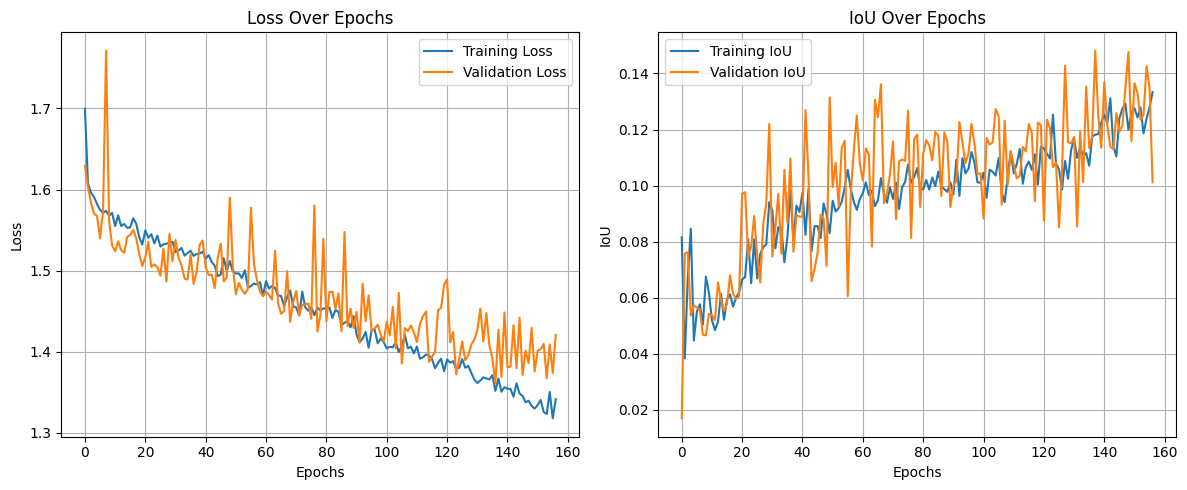

In [36]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))

# Convert GPU tensors to CPU for plotting (to avoid errors)
train_loss = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_loss']]
val_loss = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_loss']]
train_metrics = [x.cpu().item() if torch.is_tensor(x) else x for x in history['train_metrics']]
val_metrics = [x.cpu().item() if torch.is_tensor(x) else x for x in history['val_metrics']]

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot IoU
plt.subplot(1, 2, 2)
plt.plot(train_metrics, label='Training IoU')
plt.plot(val_metrics, label='Validation IoU')
plt.title('IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Note that the loss is very noisy due to a relatively large learning rate, which has been set that way to avoid plateaus that we were encountering with a low learning rate. Compared to the Sentinel-2 L2A model training, we can observe that performance does not improve as much as the number of epochs increases - there does not seem to be as many patterns for learning as for the Sentinel-2 L2A data.